In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

1329680


In [2]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn
import ImageAnalysis3 as ia3
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast
from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.correction_tools.alignment import generate_drift_crops
from ChromAn.src.spot_tools.match_spots import colocalize_spots

import pickle

In [3]:
import matplotlib.pyplot as plt

In [4]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')
# figure_folder
figure_folder = os.path.join(analysis_folder, 'saved_figures_20231018')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie
-- 19 folders, 181 fovs detected.


In [5]:
color_usage_filename = os.path.join(analysis_folder, "Color_Usage.csv")
color_usage_df = data_organization.Color_Usage(color_usage_filename)

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/Color_Usage.csv


In [6]:
save_folder = analysis_folder
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
import re
match = re.match(r'.*_([0-9]+).hdf5', os.path.basename(save_filenames[0]), ).groups()[0]
save_filenames = [_f for _f in sorted(save_filenames, 
                                      key=lambda _v:int(re.match(r'.*_([0-9]+).hdf5', os.path.basename(_v), ).groups()[0]))]

In [7]:
processed_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                       if '_processed_info.pkl' in _fl]
processed_filenames = [_f for _f in sorted(processed_filenames, 
                                      key=lambda _v:int(re.match(r'.*_([0-9]+)_processed_info.pkl', os.path.basename(_v), ).groups()[0]))]

print(len(processed_filenames))

120


In [63]:
# load infos:
all_intbc_ims = []
all_edit_ims = []
for _fl in processed_filenames:
    #print(_fl)
    _fov_info = pickle.load(open(_fl, 'rb'))
    for _info in _fov_info:
        if np.shape(_info['intbc_ims']) != (21,7,7,7) or np.shape(_info['edit_ims']) != (27,7,7,7):
            continue
        all_intbc_ims.append(_info['intbc_ims'])
        all_edit_ims.append(_info['edit_ims'])
    # extract all edits ims
    print(f" loaded {len(_fov_info)} from file: {os.path.basename(_fl)}")

all_intbc_ims = np.array(all_intbc_ims)
all_edit_ims = np.array(all_edit_ims)

print(f"- {len(all_intbc_ims)} in total")

 loaded 119 from file: Conv_zscan_000_processed_info.pkl
 loaded 116 from file: Conv_zscan_001_processed_info.pkl
 loaded 37 from file: Conv_zscan_002_processed_info.pkl
 loaded 58 from file: Conv_zscan_003_processed_info.pkl
 loaded 79 from file: Conv_zscan_004_processed_info.pkl
 loaded 91 from file: Conv_zscan_005_processed_info.pkl
 loaded 59 from file: Conv_zscan_006_processed_info.pkl
 loaded 78 from file: Conv_zscan_007_processed_info.pkl
 loaded 57 from file: Conv_zscan_008_processed_info.pkl
 loaded 72 from file: Conv_zscan_009_processed_info.pkl
 loaded 53 from file: Conv_zscan_010_processed_info.pkl
 loaded 136 from file: Conv_zscan_011_processed_info.pkl
 loaded 95 from file: Conv_zscan_012_processed_info.pkl
 loaded 81 from file: Conv_zscan_013_processed_info.pkl
 loaded 60 from file: Conv_zscan_014_processed_info.pkl
 loaded 96 from file: Conv_zscan_015_processed_info.pkl
 loaded 140 from file: Conv_zscan_016_processed_info.pkl
 loaded 69 from file: Conv_zscan_017_process

In [65]:
# Save to temp location
temp_folder = r'/lab/solexa_weissman/puzheng/PE_LT/Analysis/1030_top8'
if not os.path.isdir(temp_folder):
    os.makedirs(temp_folder)
# ims files:
intbcIm_filename = os.path.join(temp_folder, 'intbc_ims.npy')
editIm_filename = os.path.join(temp_folder, 'edit_ims.npy')
print(intbcIm_filename, editIm_filename)
np.save(intbcIm_filename, np.array(all_intbc_ims))
np.save(editIm_filename, np.array(all_edit_ims))

/lab/solexa_weissman/puzheng/PE_LT/Analysis/1030_top8/intbc_ims.npy /lab/solexa_weissman/puzheng/PE_LT/Analysis/1030_top8/edit_ims.npy


In [10]:
# reload from here:
temp_folder = r'/lab/solexa_weissman/puzheng/PE_LT/Analysis/1030_top8'
if 'all_intbc_ims' not in locals():
    
    intbcIm_filename = os.path.join(temp_folder, 'intbc_ims.npy')
    editIm_filename = os.path.join(temp_folder, 'edit_ims.npy')
    print(intbcIm_filename, editIm_filename)
    all_intbc_ims = np.load(intbcIm_filename, )
    all_edit_ims = np.load(editIm_filename, )


In [25]:
# only keep center
cropped_intbc_ims = np.array(all_intbc_ims)
cropped_edit_ims = np.array(all_edit_ims)

# Load codebook

In [66]:
codebook_filename = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/NewTargetSites/IntBC_MERFISH/full_codebook.csv'
codebook = pd.read_csv(codebook_filename)

In [67]:
# mimic MERLin Optimization, prepare data:
def find_image_background(im, dtype=None, bin_size=10, make_plot=False, max_iter=10):
    """Function to calculate image background
    Inputs: 
        im: image, np.ndarray,
        dtype: data type for image, numpy datatype (default: np.uint16) 
        bin_size: size of histogram bin, smaller -> higher precision and longer time,
            float (default: 10)
    Output: 
        _background: determined background level, float
    """
    from scipy.signal import find_peaks
    if dtype is None:
        dtype = im.dtype 
    _cts, _bins = np.histogram(im, 
                               bins=np.arange(np.iinfo(dtype).min, 
                                              np.iinfo(dtype).max,
                                              bin_size)
                               )
    _peaks = []
    # gradually lower height to find at least one peak
    _height = np.size(im)/50
    _iter = 0
    while len(_peaks) == 0:
        _height = _height / 2 
        _peaks, _params = find_peaks(_cts, height=_height)
        _iter += 1
        if _iter > max_iter:
            break
    # select highest peak
    if _iter > max_iter:
        _background = np.nanmedian(im)
    else:
        _sel_peak = _peaks[np.argmax(_params['peak_heights'])]
        # define background as this value
        _background = (_bins[_sel_peak] + _bins[_sel_peak+1]) / 2
    # plot histogram if necessary
    if make_plot:
        import matplotlib.pyplot as plt
        plt.figure(dpi=100)
        plt.hist(np.ravel(im), bins=np.arange(np.iinfo(dtype).min, 
                                              np.iinfo(dtype).max,
                                              bin_size))
        plt.xlim([np.min(im), np.max(im)])     
        plt.show()

    return _background

class Optimization_decode():
    """
    An analysis class for decoding MERFISH data
    """
    def __init__(self, codebook_filename, 
                 color_usage_filename=None,
                 parameter_filename=None,
                 verbose=True,
                 ):
        # direct inputs
        self.verbose = verbose
        # load inputs
        self.codebook_filename = codebook_filename
        self._load_codebook()
        self.color_usage_filename = color_usage_filename
        self._load_color_usage()
        # paramters
        self.parameter_filename = parameter_filename
        self.prev_scale_factors = []
        self.prev_backgrounds = []

    def _load_color_usage(self):
        """
        Load color usage from file
        """
        if not hasattr(self, 'color_usage_df') or self.color_usage_df is None:
            if self.verbose:
                print(f"-- loading color usage from file: {self.color_usage_filename}")
            self.color_usage_df = data_organization.Color_Usage(self.color_usage_filename, verbose=False)
        else:
            pass
    
    def _load_codebook(self):
        """
        Load codebook from file
        """
        if not hasattr(self, 'codebook') or self.codebook is None:
            if self.verbose:
                print(f"-- loading codebook from file: {self.codebook_filename}")
            self.codebook = pd.read_csv(self.codebook_filename)
        else:
            pass
    
    def _load_images(self, cropped_ims):
        """
        include loaded images into the class, for now its a test case
        """
        # add loaded images
        self.ims = np.array(cropped_ims)
        return
    
    def _init_scale_factors(
            self, 
            n_bins=4000,      
            scale_max=0.99,
        ) -> np.ndarray:
        """
        initialize scale factors
        """
        self.scale_factors = np.ones((self.ims.shape[0], self.ims.shape[1]), dtype=np.float32)
        data_type = self.ims.dtype
        ## TODO: add reading for bits information
        bits = np.arange(self.ims.shape[1])
        scale_factors, backgrounds = [], []
        for bit in bits:
            # calculate cumulative histogram
            counts, intensities =  np.histogram(np.array(self.ims)[:,bit], bins=np.arange(np.iinfo(data_type).min, 
                                                                                np.iinfo(data_type).max+1,
                                                                                (np.iinfo(data_type).max+1 - np.iinfo(data_type).min)/n_bins))
                                                                                
            intensities = (intensities[:-1] + intensities[1:]) / 2
            cumsum_counts = np.cumsum(counts)
            cumsum_counts = cumsum_counts / cumsum_counts[-1]

            # calculate background
            background = find_image_background(np.array(self.ims)[:,bit], )
            backgrounds.append(background)
            scaling_factor = np.ceil(intensities[np.argmin(np.abs(cumsum_counts - scale_max))])
            #scale_factors.append(max(scaling_factor - background, 1))
            scale_factors.append(scaling_factor+1)
            print(bit, scaling_factor, background) 
        # add attribute
        self.scale_factors = np.array(scale_factors)
        self.backgrounds = np.array(backgrounds)
        return np.array(scale_factors), np.array(backgrounds)
        
    def _get_previous_scale_factors(self) -> np.ndarray:
        if 'previous_iteration' not in self.parameters:
            scaleFactors = self._init_scale_factors()
        else:
            previousIteration = self.dataSet.load_analysis_task(
                self.parameters['previous_iteration'])
            scaleFactors = previousIteration.get_scale_factors()

        return scaleFactors

    def _get_previous_backgrounds(self) -> np.ndarray:
        if 'previous_iteration' not in self.parameters:
            backgrounds = np.zeros(self.get_codebook().get_bit_count())
        else:
            previousIteration = self.dataSet.load_analysis_task(
                self.parameters['previous_iteration'])
            backgrounds = previousIteration.get_backgrounds()

        return backgrounds
    
    def _decode_foci(
        self, 
        image_series=None, 
        codebook:pd.DataFrame=None,
        scale_factors:np.ndarray=None,
        backgrounds:np.ndarray=None,
        distance_threshold:int=1.44,
        magnitute_threshold:int=1,
        lowpass_threshold:int=1,        
        ) -> int:
        """
        Assign barcodes to each foci
        Each image_series has been preprocessed and aligned, 
        then according to the scaling factor and background, 
        this focus is normalized into a vector and assigned to specific barcode based on Euclidean distance
        to one of the existing barcode
        """
        # Inputs
        if image_series is None:
            # num_foci x num_bits x dx x dy x dz
            image_series = self.ims
        if scale_factors is None:
            scale_factors = self.scale_factors
        if backgrounds is None:
            backgrounds = self.backgrounds
        if codebook is None:
            codebook = self.codebook
        _codebook_mat = codebook.iloc[:,1:].values # get codebook mat
        # init assigned_infos:
        self.barcode_ids, self.barcode_dists, self.barcode_mags = [], [], []
        # normalize images
        for _i, _images in enumerate(image_series):
            #_signal_series = scoreatpercentile(_images.reshape((_images.shape[0],-1)), 95, axis=1)
            _signal_series = _images 
            _normalized_series = (_signal_series - backgrounds[:,np.newaxis,np.newaxis,np.newaxis]) / scale_factors[:,np.newaxis,np.newaxis,np.newaxis]        
            # refit, anything not fully normalized forced to be 1 at max
            _normalized_barcode = np.array([np.clip(np.max(_n), 0, 1) for _n in _normalized_series])
            # calculate Euclidian distance to existing barcodes 
            _barcode_dists = np.linalg.norm(_codebook_mat - _normalized_barcode, axis=1) 
            # assign the best
            _assigned_barcode_id = np.argmin(_barcode_dists)
            _assigned_dist = np.min(_barcode_dists)
            # calculate magnitute:
            _assigned_mag = np.linalg.norm(_normalized_barcode[_codebook_mat[_assigned_barcode_id]])
            # check if this could be assigned:
            if _assigned_dist < distance_threshold and _assigned_mag > magnitute_threshold:
                pass
            else:
                _assigned_barcode_id = -1
            #append
            self.barcode_ids.append(_assigned_barcode_id)
            self.barcode_dists.append(_assigned_dist)
            self.barcode_mags.append(_assigned_mag)

        return self.barcode_ids, self.barcode_dists, self.barcode_mags
    
    # update params
    def _update_background_scale_factors(
        self, 
        codebook:pd.DataFrame=None,
        n_bins=2000,  
        scale_max=0.95,
        ):
        if codebook is None:
            codebook = self.codebook
        _codebook_mat = codebook.iloc[:,1:].values

        if not hasattr(self, 'barcode_ids'):
            raise AttributeError("No barcode_ids detected, probably haven't run any decoding yet.")
        # select successful decoded
        #_sel_barcode_ids = np.array(self.barcode_ids)[np.array(self.barcode_ids) >= 0]
        _sel_barcodes = _codebook_mat[self.barcode_ids]
        ## TODO: add reading for bits information
        bits = np.arange(self.ims.shape[1])
        scale_factors, backgrounds = [], []
        for _bit in bits:
            ## select positive and negative images:
            binary_flags = _sel_barcodes[:,_bit].astype(bool)
            data_type = self.ims.dtype
            pos_ims = np.array(self.ims)[binary_flags & (np.array(self.barcode_ids) >=0), _bit]
            neg_ims = np.array(self.ims)[~binary_flags & (np.array(self.barcode_ids) >=0), _bit]
            ## get scale factor from positive images:
            counts, intensities =  np.histogram(pos_ims, bins=np.arange(np.iinfo(data_type).min, 
                                                                        np.iinfo(data_type).max+1,
                                                                        (np.iinfo(data_type).max+1 - np.iinfo(data_type).min)/n_bins))

            intensities = (intensities[:-1] + intensities[1:]) / 2
            cumsum_counts = np.cumsum(counts)
            cumsum_counts = cumsum_counts / cumsum_counts[-1]
            scaling_factor = np.ceil(intensities[np.argmin(np.abs(cumsum_counts - scale_max))])
            scale_factors.append(scaling_factor+1)
            ## get background from negative
            background = np.median(neg_ims)#find_image_background(neg_ims, )
            backgrounds.append(background)

            print(_bit, len(pos_ims), len(neg_ims), end=', ')
            print(self.scale_factors[_bit], scale_factors[_bit], end=', ')
            print(self.backgrounds[_bit], backgrounds[_bit])
        # store previous factors
        self.prev_scale_factors.append(np.copy(self.scale_factors))
        self.prev_backgrounds.append(np.copy(self.backgrounds))
        # replace attribute with new factors
        self.scale_factors = np.array(scale_factors)
        self.backgrounds = np.array(backgrounds)

        return scale_factors, backgrounds
    
    # final function to run analysis
    def run_analysis_decode(
        self,
        images,
        n_iter=5,
        params={},
        ):
        """Final call function to run iterations"""
        # load image
        self._load_images(images)
        # init
        self._init_scale_factors()
        for _iter in range(n_iter):
            # decode
            self._decode_foci()
            # update_param
            self._update_background_scale_factors()
            valid_list = [0,364,348,255,270,265,263,283,227,356,369,314,341,305,74,68,64,101,99,95,17,14,12,11,30]
            sel_barcode_ids = np.array(self.barcode_ids)[np.array(self.barcode_ids) >= 0]
            print(len([_id for _id in sel_barcode_ids if _id in valid_list]) / len(sel_barcode_ids), np.mean(np.array(self.barcode_ids) >= 0))

        return


In [68]:
from scipy.stats import scoreatpercentile

In [69]:
# test case:
optimize_obj = Optimization_decode(codebook_filename, color_usage_filename, verbose=True)
optimize_obj.run_analysis_decode(cropped_intbc_ims)

-- loading codebook from file: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/NewTargetSites/IntBC_MERFISH/full_codebook.csv
-- loading color usage from file: /lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/Color_Usage.csv
0 10593.0 2315.0
1 13935.0 3485.0
2 4105.0 1965.0
3 3417.0 1395.0
4 6104.0 2435.0
5 4596.0 2325.0
6 4465.0 1515.0
7 3204.0 2185.0
8 5022.0 2585.0
9 4383.0 1545.0
10 5514.0 2415.0
11 4662.0 2705.0
12 4023.0 1525.0
13 4465.0 2435.0
14 5497.0 2965.0
15 3318.0 1505.0
16 4678.0 2445.0
17 5563.0 3305.0
18 4170.0 1535.0
19 3974.0 2215.0
20 6251.0 3615.0
0 3644 61, 10594.0 7358.0, 2315.0 2836.0
1 2290 1415, 13936.0 10962.0, 3485.0 3550.0
2 1211 2494, 4106.0 3557.0, 1965.0 1866.0
3 1050 2655, 3418.0 3590.0, 1395.0 1423.0
4 1370 2335, 6105.0 6047.0, 2435.0 2437.0
5 1321 2384, 4597.0 4376.0, 2325.0 2280.0
6 813 2892, 4466.0 5162.0, 1515.0 1621.0
7 475 3230, 3205.0 3131.0, 2185.0 2161.0
8 671 3034, 5023.0 5294.0, 2585.0 2627.0
9 973 2732, 4384.0 4

In [70]:
edit_obj = Optimization_decode(codebook_filename, color_usage_filename, verbose=True)
edit_obj._load_images(cropped_edit_ims)
edit_obj._init_scale_factors()

-- loading codebook from file: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/NewTargetSites/IntBC_MERFISH/full_codebook.csv
-- loading color usage from file: /lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/Color_Usage.csv
0 3711.0 1365.0
1 2909.0 2075.0
2 5350.0 3425.0
3 3974.0 1285.0
4 3023.0 2195.0
5 7185.0 3555.0
6 2417.0 1095.0
7 3253.0 1985.0
8 4482.0 2605.0
9 2892.0 1315.0
10 3777.0 2195.0
11 4269.0 2415.0
12 2827.0 1195.0
13 3089.0 2175.0
14 4891.0 2785.0
15 3974.0 1335.0
16 5120.0 2285.0
17 5153.0 2935.0
18 2794.0 1345.0
19 3138.0 2195.0
20 5219.0 3135.0
21 2794.0 1305.0
22 6366.0 2535.0
23 6087.0 3505.0
24 8348.0 1685.0
25 6153.0 2685.0
26 14853.0 4215.0


(array([ 3712.,  2910.,  5351.,  3975.,  3024.,  7186.,  2418.,  3254.,
         4483.,  2893.,  3778.,  4270.,  2828.,  3090.,  4892.,  3975.,
         5121.,  5154.,  2795.,  3139.,  5220.,  2795.,  6367.,  6088.,
         8349.,  6154., 14854.]),
 array([1365., 2075., 3425., 1285., 2195., 3555., 1095., 1985., 2605.,
        1315., 2195., 2415., 1195., 2175., 2785., 1335., 2285., 2935.,
        1345., 2195., 3135., 1305., 2535., 3505., 1685., 2685., 4215.]))

In [71]:
def _normalize_sequential(
    self,
    scale_factors=None,
    backgrounds=None,
    ):
    bits = np.arange(self.ims.shape[1])
    
    
    if scale_factors is None:
        scale_factors = self.scale_factors
    if backgrounds is None:
        backgrounds = self.backgrounds
        
    normalized_ims = (self.ims - backgrounds[np.newaxis,:,np.newaxis,np.newaxis,np.newaxis]) \
        / scale_factors[np.newaxis,:,np.newaxis,np.newaxis,np.newaxis]
    normalized_barcodes = np.max(normalized_ims, (2,3,4))
    return normalized_barcodes, normalized_ims
normalized_barcodes,normalized_ims = _normalize_sequential(edit_obj)

In [72]:
# Codebook
preEdit_codebook = pd.read_excel('/lab/weissman_imaging/puzheng/Probes/preEdit_codebook.xlsx')
edit_sites = preEdit_codebook.columns[-3:]
preEdit_codebook['intbc_id'] = [int(_n.split('_')[-1].split('intBC')[-1]) for _n in preEdit_codebook['IntBC']]


In [73]:
preEdit_probebook = pd.read_excel('/lab/weissman_imaging/puzheng/Probes/preEdit_top24_probe.xlsx')
preEdit_probebook['edit_site'] = [_n.split('_')[1] for _n in preEdit_probebook['Name']]
preEdit_probebook['intbc_id'] = [int(_n.split('_')[-1].split('intBC')[-1]) for _n in preEdit_probebook['IntBC']]
site_2_indices = {_e:np.where(preEdit_probebook['edit_site']==_e)[0] for _e in edit_sites}

In [102]:
#_amplicon_id = 0
from scipy.stats import zscore

amplicon_stats = {
    'wrong':[],
    'match':[],
    'mismatch':[],
}
site_sz_list = []
site_edit_states = []
for _amplicon_id in range(len(optimize_obj.ims)):

    _assigned_barcode_id = optimize_obj.barcode_ids[_amplicon_id]
    _edit_zscores = zscore(normalized_barcodes, axis=1)[_amplicon_id]
    # Determine edit state:
    _site_2_zs = {_e:_edit_zscores[_idx] for _e,_idx in site_2_indices.items()}
    _edit_states = np.array([(np.argmax(_zs)+1)%9 for _zs in _site_2_zs.values()])
    #_site_2_normed_zs = {_e:_zs-np.max(_zs) for _e,_zs in _site_2_zs.items()}
    site_sz_list.append(_site_2_zs)
    site_edit_states.append(_edit_states)
    # skip if not assigned
    if _assigned_barcode_id <0:
        continue
        
    
    # check if Edit and intBC matches:
    if _assigned_barcode_id not in preEdit_codebook['intbc_id'].values:
        amplicon_stats['wrong'].append(_amplicon_id)
    elif (preEdit_codebook[edit_sites][preEdit_codebook['intbc_id']==_assigned_barcode_id].values[0] == _edit_states).all():
        amplicon_stats['match'].append(_amplicon_id)
    else:
        amplicon_stats['mismatch'].append(_amplicon_id)

In [103]:
counts = [len(_v) for _v in amplicon_stats.values()]
counts, counts[1] / sum(counts)

([382, 2796, 1100], 0.6535764375876578)

In [142]:
edit_2_zmat = {}
for _e in edit_sites:
    #_e = edit_sites[0]
    _zs_mat = [[] for _i in range(len(site_sz_list[0][_e]))]
    for _zss, _states in zip(site_sz_list, site_edit_states):
        _zs = _zss[_e]
        _state = _states[list(edit_sites).index(_e)]
        _zs_mat[_state-1].append(_zs)

    _zs_mat = np.array([np.mean(_zs_list, axis=0) for _zs_list in _zs_mat])
    edit_2_zmat[_e] = _zs_mat

matched_edit_2_zmat = {}
for _e in edit_sites:
    #_e = edit_sites[0]
    _zs_mat = [[] for _i in range(len(site_sz_list[0][_e]))]
    for _idx in amplicon_stats['match']:
        _zs = site_sz_list[_idx][_e]
        _state = site_edit_states[_idx][list(edit_sites).index(_e)]
        _zs_mat[_state-1].append(_zs)

    _zs_mat = np.array([np.mean(_zs_list, axis=0) for _zs_list in _zs_mat])
    matched_edit_2_zmat[_e] = _zs_mat
    
mismatched_edit_2_zmat = {}
for _e in edit_sites:
    #_e = edit_sites[0]
    _zs_mat = [[] for _i in range(len(site_sz_list[0][_e]))]
    for _idx in amplicon_stats['mismatch']:
        _zs = site_sz_list[_idx][_e]
        _state = site_edit_states[_idx][list(edit_sites).index(_e)]
        _zs_mat[_state-1].append(_zs)

    _zs_mat = np.array([np.mean(_zs_list, axis=0) for _zs_list in _zs_mat])
    mismatched_edit_2_zmat[_e] = _zs_mat

<IPython.core.display.Javascript object>


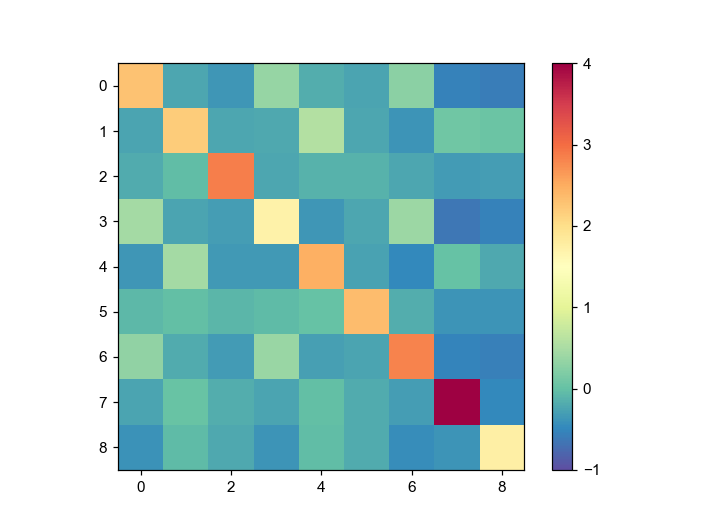

In [145]:
plt.figure()
plt.imshow(edit_2_zmat['EMX1'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


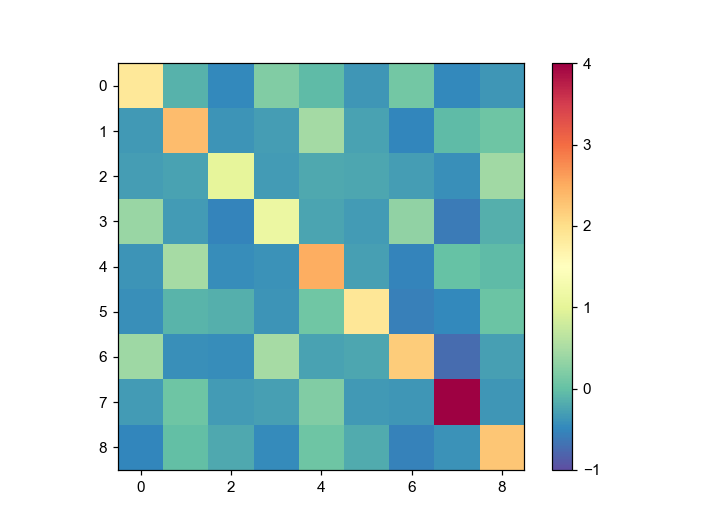

In [146]:
plt.figure()
plt.imshow(mismatched_edit_2_zmat['EMX1'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


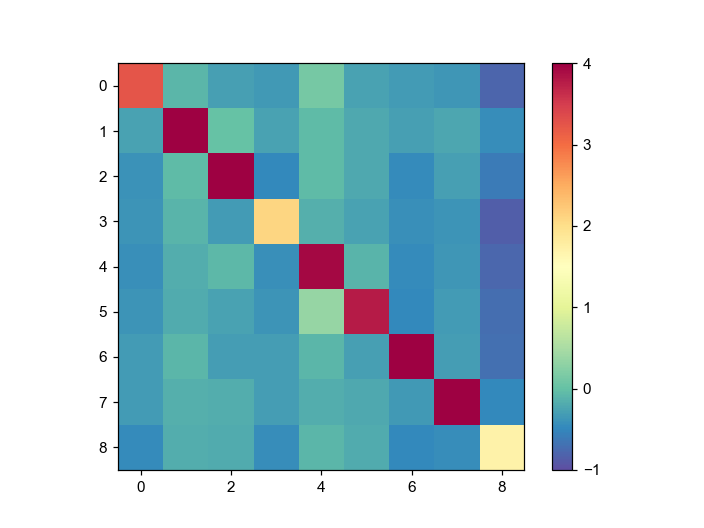

In [148]:
plt.figure()
plt.imshow(matched_edit_2_zmat['EMX1'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.show()

In [149]:
normalized_barcodes[0]

array([ 0.32381466,  0.55670103, -0.01196038,  0.12955975,  0.44047619,
        2.39451712,  0.14516129,  0.3601721 ,  0.20388133,  0.14863464,
        0.27236633, -0.02552693,  0.31400283,  0.49902913,  0.03434178,
        0.08427673,  0.260496  ,  0.09293752,  0.04293381,  0.30997133,
        0.00517241,  0.15348837,  0.21532904,  0.8695795 ,  1.06491795,
        0.46717582,  0.99791302])

<IPython.core.display.Javascript object>


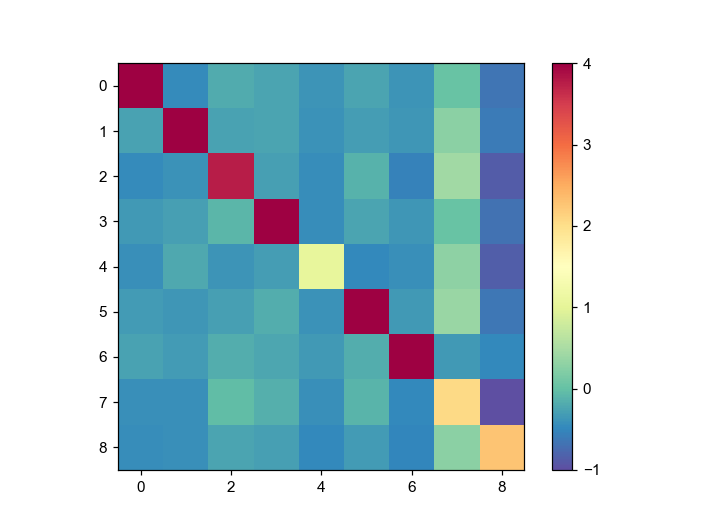

In [160]:
plt.figure()
plt.imshow(matched_edit_2_zmat['RNF2'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()

<IPython.core.display.Javascript object>


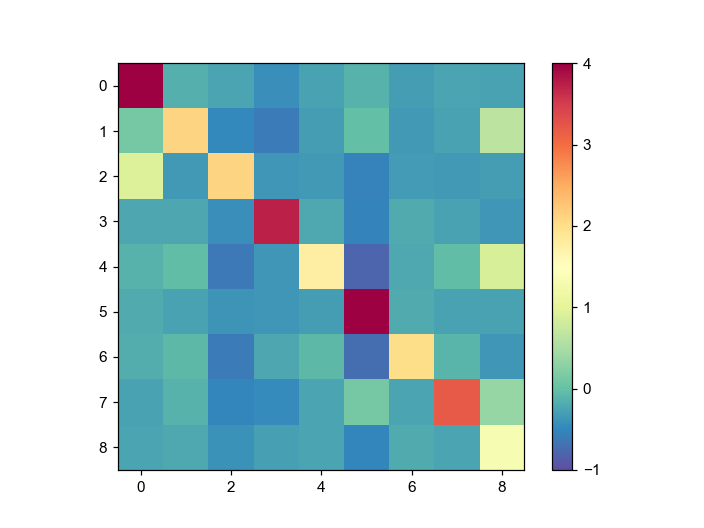

In [161]:
plt.figure()
plt.imshow(matched_edit_2_zmat['HEK3'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()

In [170]:
%matplotlib inline

In [173]:
plt.style.use('dark_background')

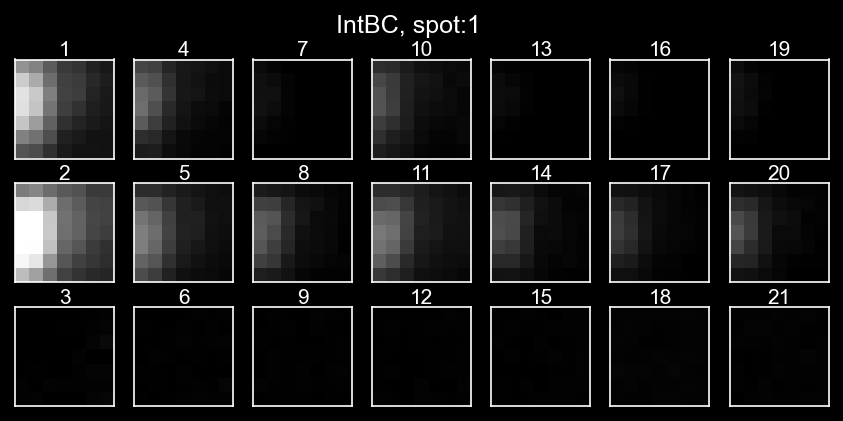

In [174]:
_sid = 1
normalized_intbc_ims = (optimize_obj.ims[_sid] - optimize_obj.backgrounds[:,np.newaxis,np.newaxis,np.newaxis]) / optimize_obj.scale_factors[:,np.newaxis,np.newaxis,np.newaxis]        
intbc_ids = np.arange(1,22)
optimize_obj.barcode_ids[_sid]


# site 1 image
fig, axes = plt.subplots(3,int(len(normalized_intbc_ims)/3), sharex=True, sharey=True, 
                         figsize=(len(normalized_intbc_ims)/3,3), dpi=150)
plt.subplots_adjust(wspace=0.2, hspace=0.25)
for _iax, ax in enumerate(np.ravel(axes.transpose())):
    ax.imshow(normalized_intbc_ims[_iax].max(0), 
              vmin=0, 
              vmax=scoreatpercentile(normalized_intbc_ims, 99.9), cmap='Greys_r')
    #ax.set_axis_off()
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False) 
    if _iax < len(normalized_intbc_ims):
        ax.set_title(f"{intbc_ids[_iax]}", fontsize=10, pad=1)
    else:
        pass
        #ax.set_title("unedited", fontsize=10)

fig.suptitle(f'IntBC, spot:{_sid}', fontsize=12)
fig.savefig(os.path.join(figure_folder,
                         f"temp_IntBC_decode_{_sid}.png"),
            transparent=True,
           )
plt.show()

In [166]:
optimize_obj.barcode_ids[_sid]

-1

In [41]:
foci_id = 102

from scipy.stats import zscore
zscore(normalized_barcodes, axis=1)[foci_id], optimize_obj.barcode_ids[foci_id]

(array([-0.37312424,  1.96896047, -0.2346025 , -0.63080555, -1.09268233,
         0.22058248, -0.78130192, -0.64632086, -0.30633873,  0.05295595,
        -0.69160376, -0.21504766,  0.26904848,  0.24988542, -0.51985527,
        -0.5252505 , -0.76584741,  0.38724593, -0.88607892, -0.89025315,
        -0.60267836,  0.40449235,  0.12072863, -0.22889851,  2.58681039,
         0.07165117,  3.05832841]),
 101)

<IPython.core.display.Javascript object>


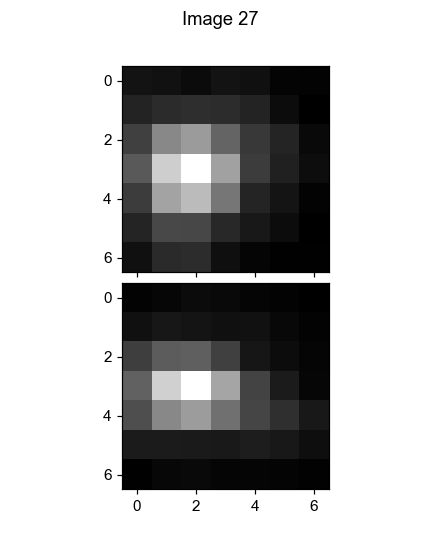

In [42]:
%matplotlib notebook
interactive.imshow_mark_3d(edit_obj.ims[foci_id])

In [49]:
%matplotlib notebook
interactive.imshow_mark_3d(normalized_barcodes[100])

AxisError: axis 1 is out of bounds for array of dimension 0

# Load pre-edited codebook

In [61]:
preEdit_codebook = pd.read_excel('/lab/weissman_imaging/puzheng/Probes/preEdit_codebook.xlsx')
preEdit_codebook['edit_site'] = [_n.split('_')[1] for _n in preEdit_codebook['Name']]
preEdit_codebook['intbc_id'] = [int(_n.split('_')[-1].split('intBC')[-1]) for _n in preEdit_codebook['IntBC']]
edit_sites = np.unique(preEdit_codebook['edit_site'])
np.where(preEdit_codebook['edit_site']==edit_sites[0])[0]

array([ 8,  9, 10, 11, 12, 13, 14, 15, 24])

In [60]:
edit_sites

array(['EMX1', 'HEK3', 'RNF2'], dtype=object)

<IPython.core.display.Javascript object>


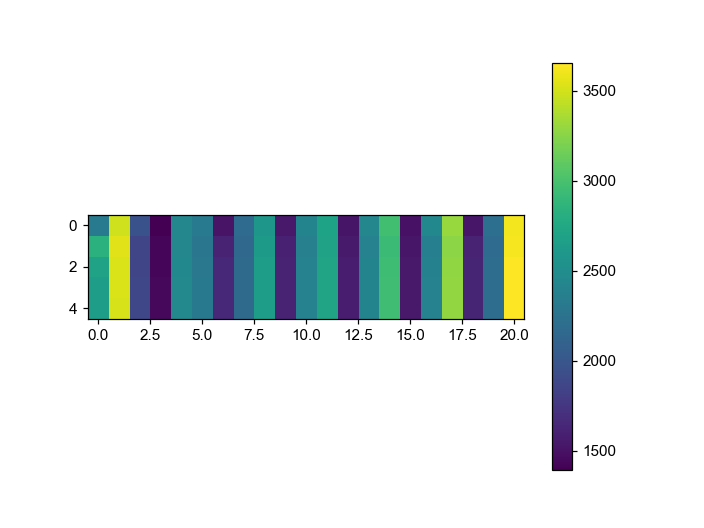

In [62]:
plt.figure()
plt.imshow(np.array(optimize_obj.prev_backgrounds))
plt.colorbar()

<IPython.core.display.Javascript object>


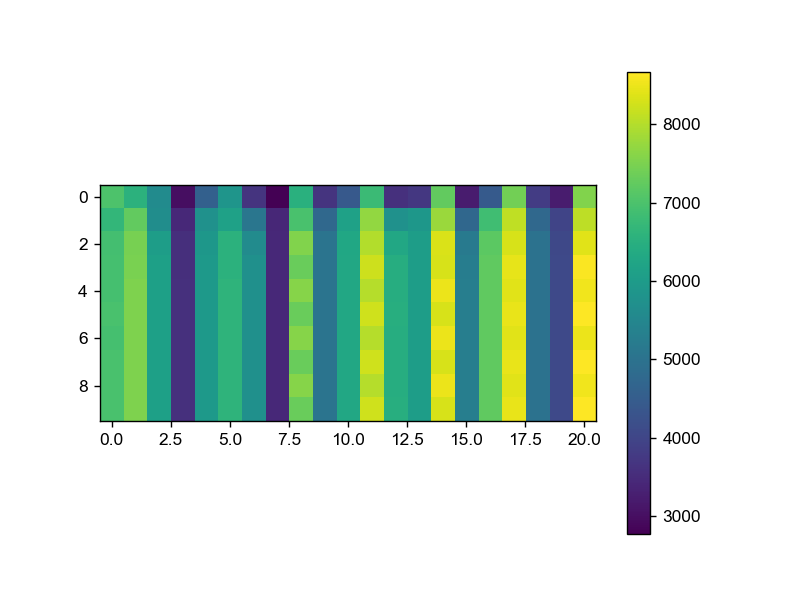

In [226]:
plt.figure()
plt.imshow(np.array(optimize_obj.prev_scale_factors))
plt.colorbar()

<IPython.core.display.Javascript object>


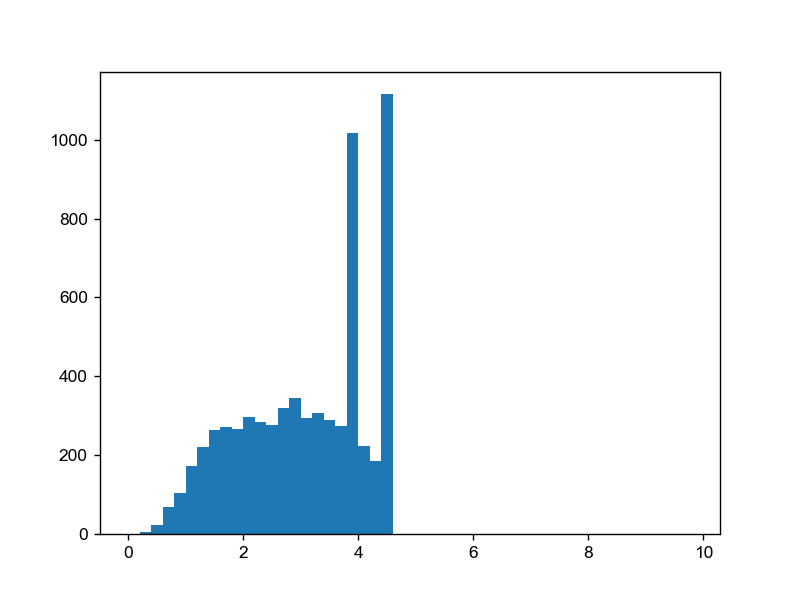

In [124]:
plt.figure()
plt.hist(np.array(optimize_obj.barcode_mags),bins=np.arange(0,10,0.2))
plt.show()

<IPython.core.display.Javascript object>


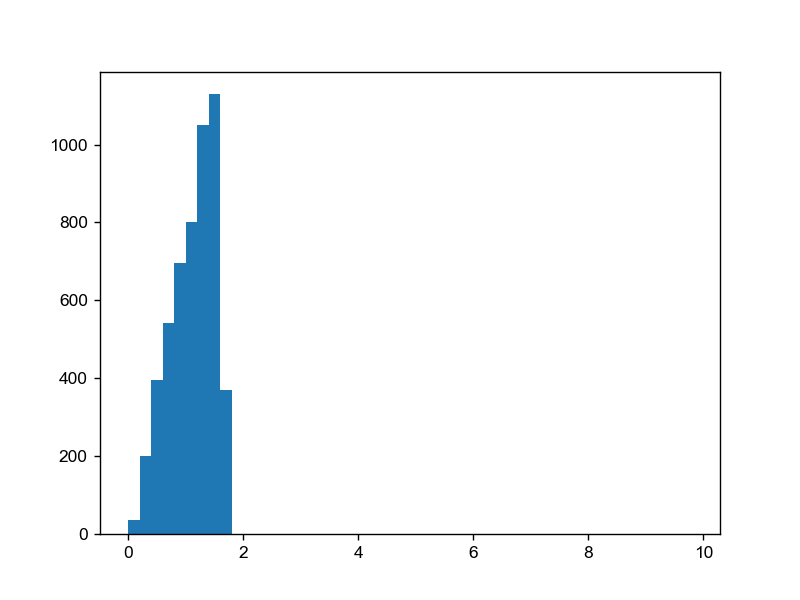

In [227]:
plt.figure()
plt.hist(np.array(optimize_obj.barcode_dists),bins=np.arange(0,10,0.2))
plt.show()

In [62]:
# dist allowing linear regression
from sklearn.linear_model import LinearRegression
_background_mag = 1
_signal_mag = 1


In [85]:
_image_series = np.max(optimize_obj.ims[0], axis=(1,2,3))
coefs, intercepts, scores = [], [], []
for _ibc, _barcode in enumerate(codebook_mat):
    # normalize:
    backgrounds = optimize_obj.backgrounds
    scale_factors = optimize_obj.scale_factors
    # define XY
    X, y = np.transpose([backgrounds*_barcode, scale_factors*_barcode]), _image_series * _barcode
    model = LinearRegression(positive=True, fit_intercept=True)
    model.fit(X, y)
    coefs.append(model.coef_)
    intercepts.append(model.intercept_)
    scores.append(model.score(X, y))

<IPython.core.display.Javascript object>


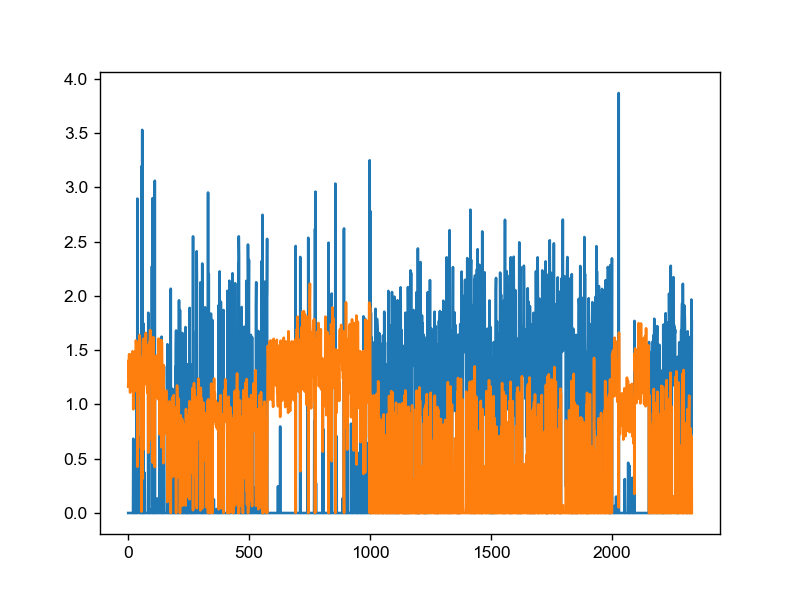

In [91]:
plt.figure()
plt.plot(np.array(coefs))

<IPython.core.display.Javascript object>


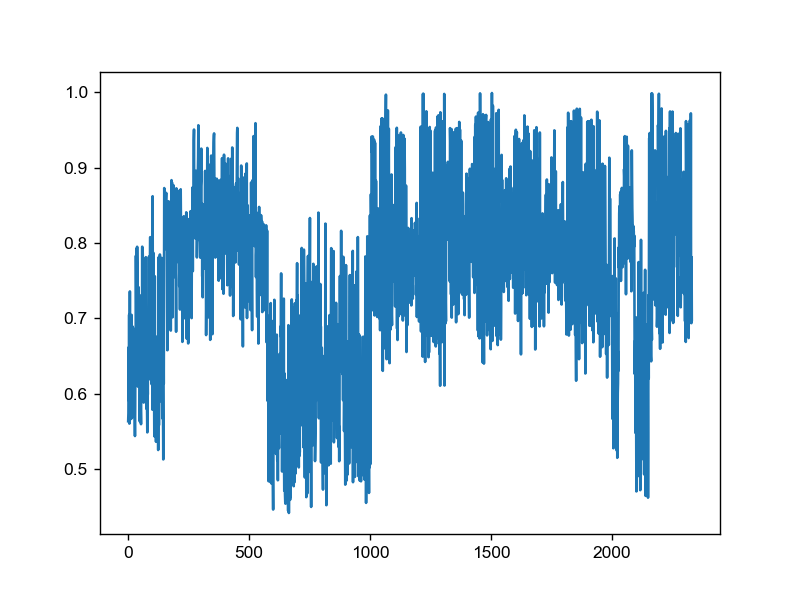

In [88]:

plt.figure()
plt.plot(scores)

0.16962473870632444

(array([0.2885317 , 0.88399317]), -67.12336972597586)

In [69]:
_image_series

array([ 7967, 18425,  2789,  1636,  4122,  7679,  1783,  3430,  3445,
        1789,  3602,  3593,  1737,  3765, 10893,  1750,  5141,  3726,
        6885,  7814,  3544], dtype=uint16)

In [37]:
np.max(normed_series, axis=(1,2,3))

array([0.79118065, 2.37863339, 0.00782779, 0.107     , 0.39733217,
       0.82789267, 0.01586867, 0.50361011, 0.05994467, 0.03666211,
       0.28509866, 0.05705043, 0.05905292, 0.38430529, 1.06033058,
       0.06348715, 0.63169743, 0.07422875, 1.34590207, 1.74326417,
       0.03031105])

In [39]:
codebook_mat = codebook.iloc[:,1:].values

In [61]:
codebook

,Unnamed: 0,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,...,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_20
0,intbc_0,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,intbc_1,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,intbc_2,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,intbc_3,1,1,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,intbc_4,1,1,1,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,blank_325,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,0,0,1
2326,blank_326,0,0,0,0,0,0,0,0,1,...,0,1,1,1,1,0,0,0,0,1
2327,blank_327,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,1,1,1
2328,blank_328,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,0,0


In [49]:
np.min(barcode_dists), np.argmin(barcode_dists)

(1.0708112559355, 101)

In [51]:
np.argsort(barcode_dists)[:10]

array([101, 786, 934, 815,  91, 148, 999,  73, 526,  96])

In [50]:
np.sort(barcode_dists)[:10]

array([1.07081126, 1.71088091, 1.80490272, 1.8219506 , 1.83597547,
       1.84134997, 1.86793964, 1.93316907, 1.93989598, 1.93993622])

<IPython.core.display.Javascript object>


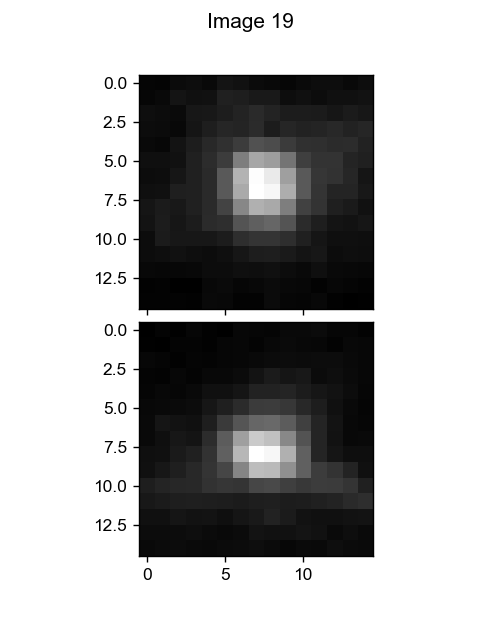

In [82]:
%matplotlib notebook
interactive.imshow_mark_3d(normed_series)

In [21]:
norm[:,7,7,7], norm[:,8,8,8]

NameError: name 'norm' is not defined

In [22]:
np.sort(np.max(dists, axis=(1,2,3)))[:5], np.argsort(np.max(dists, axis=(1,2,3)))[:5]#, np.min(np.max(dists, axis=(1,2,3)))

NameError: name 'dists' is not defined

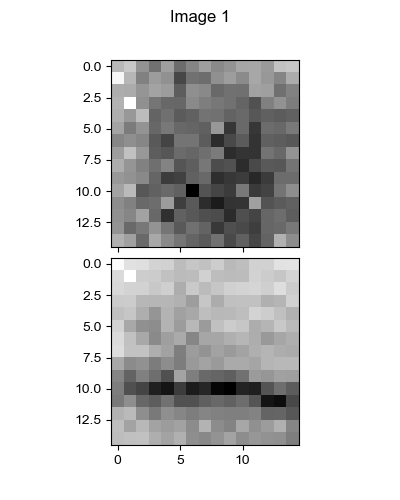

In [233]:
interactive.imshow_mark_3d(dists[np.array([101,815,999])])

array([[1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [35]:
cumHist = np.cumsum(all_intbc_ims, axis=1)

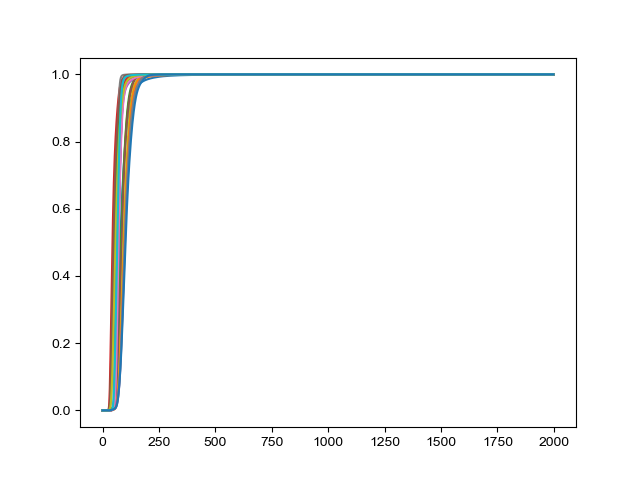

In [98]:
plt.figure()
plt.plot(np.array(all_cumHist).transpose(),)
plt.show()

0 4604.0 2345.0
1 4178.0 2605.0
2 4015.0 2435.0
3 2442.0 1235.0
4 3261.0 2205.0
5 4113.0 2625.0
6 2802.0 1585.0
7 2442.0 1995.0
8 4441.0 2875.0
9 2835.0 1635.0
10 3130.0 2255.0
11 4539.0 2925.0
12 2900.0 1425.0
13 3064.0 2205.0
14 4867.0 3035.0
15 2606.0 1355.0
16 3228.0 2255.0
17 4801.0 3015.0
18 3064.0 1705.0
19 2802.0 2025.0
20 5063.0 3085.0


In [ ]:
len(all_intbc_ims)

1708

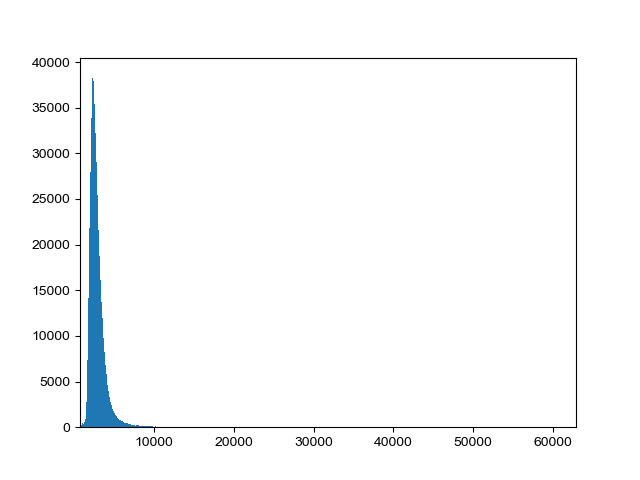

2345.0

In [ ]:
find_image_background(np.array(all_intbc_ims)[:,0], make_plot=True)

In [ ]:
np.iinfo(data_type).max

65535

In [ ]:
pixelHist

(array([5693805,   61808,    6514,    1545,     533,     193,      58,
             29,      10,       5]),
 array([  694. ,  6914.1, 13134.2, 19354.3, 25574.4, 31794.5, 38014.6,
        44234.7, 50454.8, 56674.9, 62895. ]))

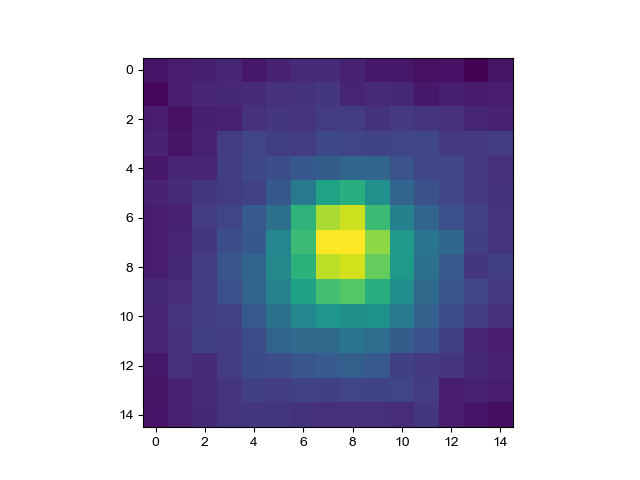

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cumHist[0][0].mean(0))
plt.show()

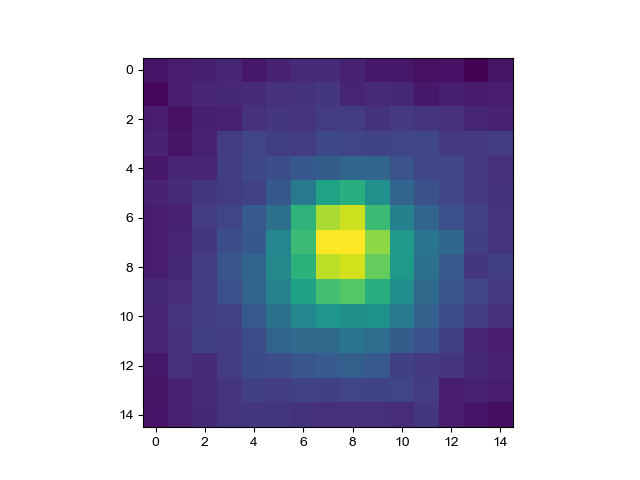

In [ ]:
plt.figure()
plt.imshow(all_intbc_ims[0][0].mean(0))
plt.show()

In [175]:
# save this object:
intbc_save_filename = os.path.join(save_folder, 'intbc_decoder.pkl')
print(intbc_save_filename)
with open(intbc_save_filename, 'wb') as _f:
    pickle.dump(optimize_obj, _f)

/lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/intbc_decoder.pkl


In [176]:
# save this object:
edit_save_filename = os.path.join(save_folder, 'edit_decoder.pkl')
print(edit_save_filename)
with open(edit_save_filename, 'wb') as _f:
    pickle.dump(edit_obj, _f)

/lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/edit_decoder.pkl


In [177]:
# load
loaded_intbc_obj = pickle.load(open(intbc_save_filename, 'rb'))
loaded_edit_obj = pickle.load(open(edit_save_filename, 'rb'))